# Interacting with ProtoDash

In this notebook we'll combine the ProtoDash and the Partial Effects to obtain feature importances on the digits classifications task.

ProtoDash was proposed in _Gurumoorthy, Karthik & Dhurandhar, Amit & Cecchi, Guillermo & Aggarwal, Charu. (2019). Efficient Data Representation by Selecting Prototypes with Importance Weights. 260-269. 10.1109/ICDM.2019.00036_.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp # v0.2.13

import shap
from sklearn.metrics import classification_report

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from aix360.algorithms.protodash import ProtodashExplainer, get_Gaussian_Data

import warnings
warnings.filterwarnings(action='ignore',module=r'itea.*')

In [2]:
digits_data = datasets.load_digits(n_class=10)

X, y        = digits_data['data'], digits_data['target']
labels      = digits_data['feature_names']
targets     = digits_data['target_names']

X /= X.max(axis=1).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'id' : lambda x: x,
    'sin': jnp.sin,
    'cos': jnp.cos,
    'tan': jnp.tan
}

clf = ITEA_classifier(
    gens            = 300,
    popsize         = 300,
    max_terms       = 40,
    expolim         = (0, 2),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = None,
    random_state    = 42,
    fit_kw          = {'max_iter' : 5}
).fit(X_train, y_train)

final_itexpr = clf.bestsol_
final_itexpr.selected_features_

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.10390689941812137 	 0.10415073427542255 	 0.1055694098088113 	 64min25seg
5 	 0.10390689941812137 	 0.10555832640620674 	 0.1055694098088113 	 13min10seg
10 	 0.1055694098088113 	 0.10556940980881134 	 0.1055694098088113 	 12min40seg
15 	 0.10390689941812137 	 0.10556386810750903 	 0.1055694098088113 	 13min39seg
20 	 0.1055694098088113 	 0.10628151842615687 	 0.1778886118038238 	 14min43seg
25 	 0.1055694098088113 	 0.1146411748406761 	 0.22527015793848712 	 21min19seg
30 	 0.11970074812967581 	 0.15483236353560545 	 0.2344139650872818 	 33min40seg
35 	 0.19866999168744803 	 0.22126904959822669 	 0.2801330008312552 	 50min5seg
40 	 0.2344139650872818 	 0.28497644776946524 	 0.343308395677473 	 74min0seg
45 	 0.2801330008312552 	 0.34155167636464395 	 0.3574397339983375 	 77min16seg
50 	 0.343308395677473 	 0.3556802438348573 	 0.4056525353283458 	 83min33seg
55 	 0.35245220282626766 	 0.3745358825159324 	 0.414796342

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


array(['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4',
       'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1',
       'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6',
       'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3',
       'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0',
       'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5',
       'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7',
       'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4',
       'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1',
       'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6',
       'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3',
       'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7'], dtype='<U9')

In [3]:
print(classification_report(
    y_test,
    final_itexpr.predict(X_test),
    target_names=[str(t) for t in targets]
))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        55
           1       0.89      0.85      0.87        55
           2       0.92      0.94      0.93        52
           3       0.83      0.88      0.85        56
           4       0.92      0.89      0.90        64
           5       0.96      0.90      0.93        73
           6       0.95      0.96      0.96        57
           7       0.91      0.98      0.95        62
           8       0.82      0.77      0.79        52
           9       0.89      0.91      0.90        68

    accuracy                           0.90       594
   macro avg       0.90      0.90      0.90       594
weighted avg       0.90      0.90      0.90       594



We can use the ``ITEA_summarizer`` to inspect the convergence during the evolution. In the cell below, we'll create 3 plots, one for the fitness (classification accuracy), one for the complexity (number of nodes if the IT expression was converted to a symbolic tree) and number of terms (number of IT terms of the solutions in the population for each generation).

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


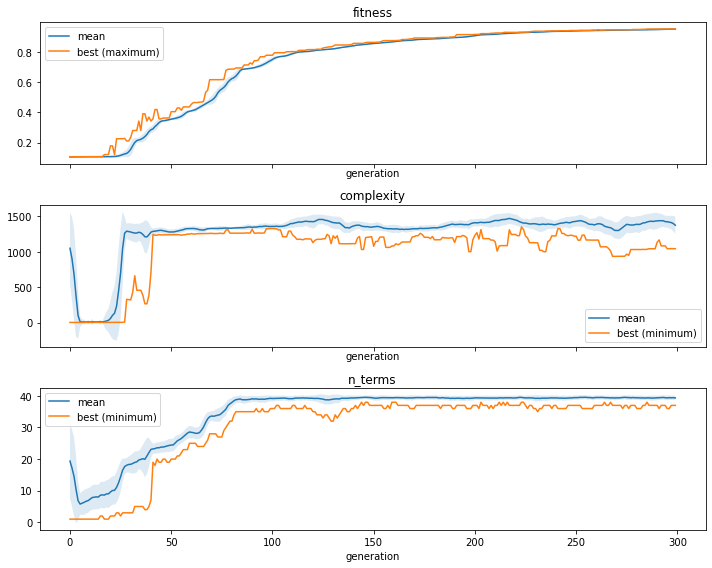

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=clf).fit(X_train, y_train).plot_convergence(
    data=['fitness', 'complexity', 'n_terms'],
    ax=ax,
    show=False
)

plt.tight_layout()
plt.show()

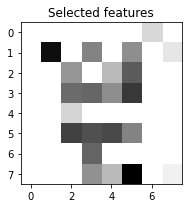

In [5]:
# features are named pixel_x_y. Lets extract those coordinates and
# paint in a figure to show the selected features

selected_features = np.zeros((8, 8))
for feature_name, feature_importance in zip(
    final_itexpr.selected_features_,
    np.sum(final_itexpr.feature_importances_, axis=0)
):
    x, y = feature_name[-3], feature_name[-1]
    selected_features[int(x), int(y)] = feature_importance

fig, axs = plt.subplots(1, 1, figsize=(3,3))

axs.imshow(selected_features, cmap='gray_r')
axs.set_title(f"Selected features")

plt.tight_layout()
plt.show()

In [6]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(
    np.hstack( (X_train, y_train.reshape(-1, 1)) ) )

explainer = ProtodashExplainer()

# call protodash explainer. We'll select 10 prototypes
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


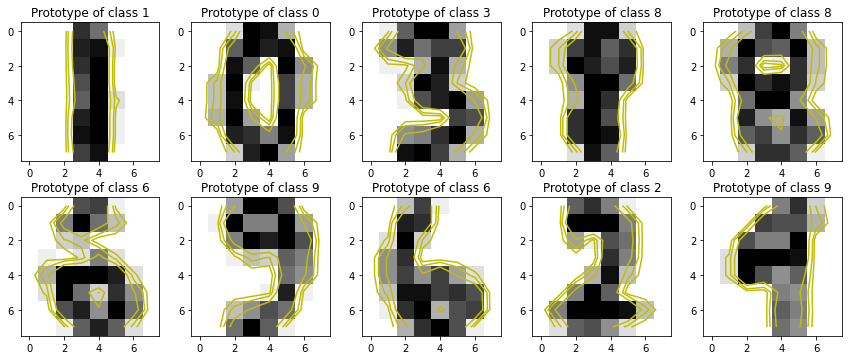

In [7]:
from matplotlib import cm

fig, axs = plt.subplots(2, 5, figsize=(12,5))

# Showing 10 prototypes
for s, ax in zip(S, fig.axes):
    ax.imshow(X_train[s].reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Prototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')


plt.tight_layout()
plt.show()

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


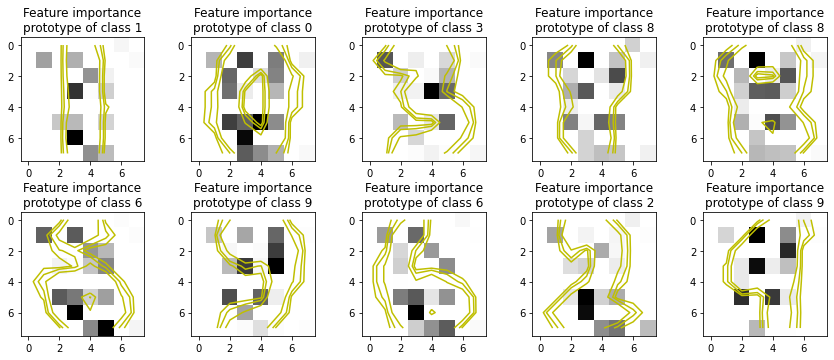

In [8]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for s, ax in zip(S, fig.axes):
    
    importances = it_explainer.average_partial_effects(X_train[s, :].reshape(1, -1))[y_train[s]]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

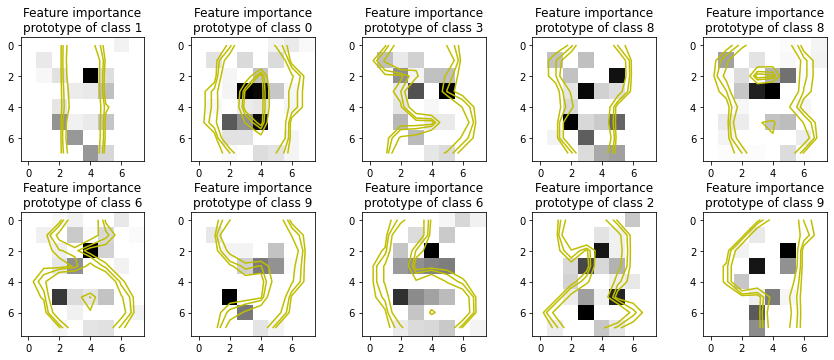

In [9]:
shap_explainer = shap.KernelExplainer(
    final_itexpr.predict,
    shap.sample(pd.DataFrame(X_train, columns=labels), 100)
)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for s, ax in zip(S, fig.axes):
    
    importances = np.abs(shap_explainer.shap_values(X_train[s, :].reshape(1, -1), silent=True))
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

It wasn't specified a dict for tfuncs_dx. They will be automatically generated using Jax. For this, make sure that the tfuncs uses the jax.numpy instead of numpy to create the transformation functions. You can access the automatic derivatives with explainer.tfuncs_dx.


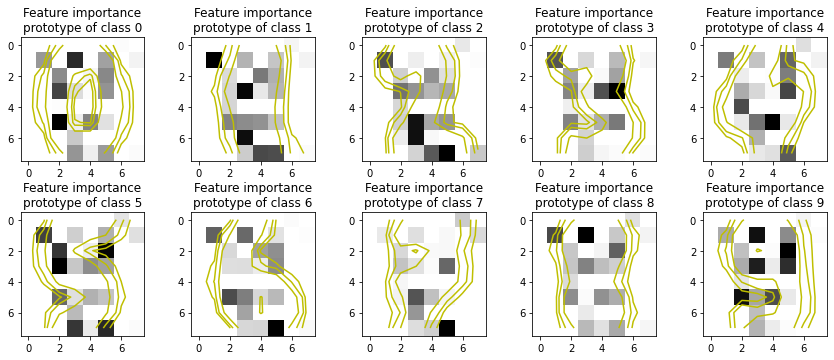

In [10]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for c, ax in zip(final_itexpr.classes_, fig.axes):
    
    c_idx = np.array([i for i in range(len(y_train)) if y_train[i]==c])
    
    importances = it_explainer.average_partial_effects(X_train[c_idx, :])[c]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {c}")
    
    Z = X_train[c_idx, :].mean(axis=0).reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()